In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Single scan, WITH TT correction

In [2]:
pgroup='p20537'
runnumber = 165

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0165


'/sf/alvra/data/p20537/raw/run0165-FePhen_timescan_7131p5eV/meta/scan.json'

In [6]:
quantile_corr = 0.4

channel_delay_motor = channel_delay_topas
Timezero_mm = 199.37992 ## 

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

TT = TT_PSEN126

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
flag = False

try:
    flag = True
    Timezero_mm = get_timezero_NBS(fc.selected)
except:
    Timezero_mm = Timezero_mm
            
(Delays_fs_scan, Delays_corr_scan, DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Pump_probe_scan,
    Izero_pump_scan, Izero_unpump_scan, correlation, readbacks, goodshots) = \
    XAS_scanPP_PSEN_bs(scan, TT, channel_delay_motor, detector_XAS, detector_Izero, Timezero_mm, quantile_corr)#, target, px2fs)

if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))
    
Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)


Processing: run0165-FePhen_timescan_7131p5eV
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET                 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 10 / 10 -> 0% incomp

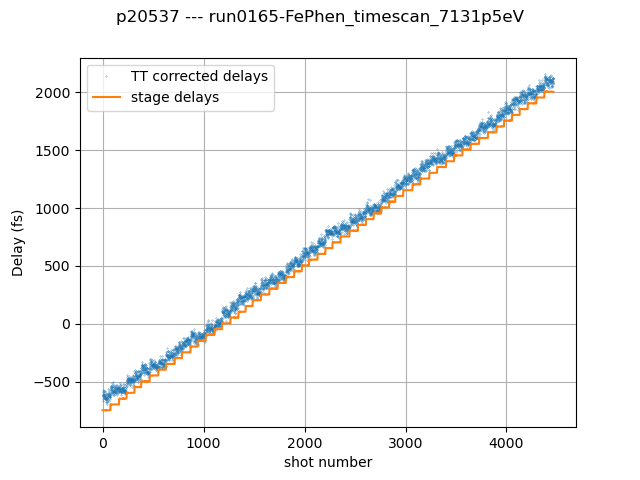

In [8]:
plt.figure()
plt.suptitle(titlestring)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

In [9]:
binsize = 25 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan))

binList = np.arange(Delays_fs_scan[0] - 100, Delays_fs_scan[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 100 + binsize/2, Delays_fs_scan[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)

(4466,) (4466,)


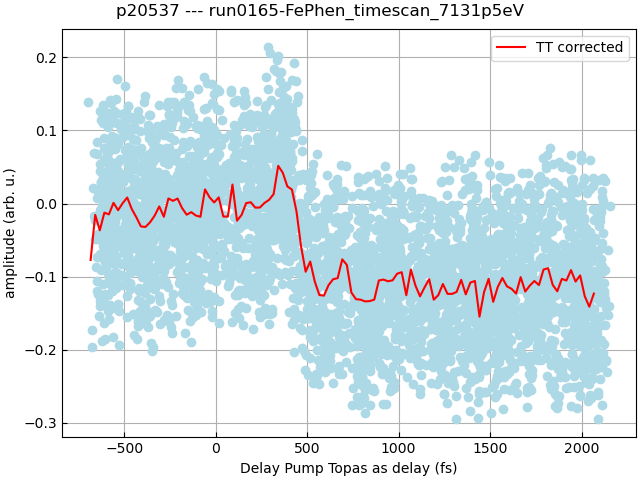

In [11]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
#plt.plot(Delay_fs_TT, pp_fit)

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
#                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
#            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

#print("Position t0_raw = {} mm".format(Timezero_mm ))
#print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

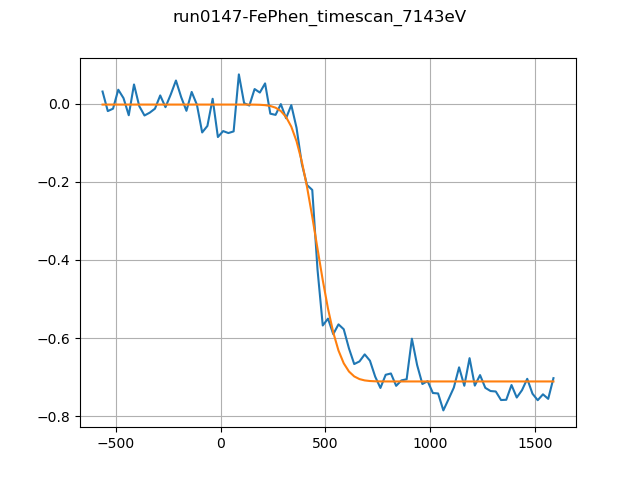

t0 = 457.5683576401946 fs
width = 201.89476067036378 fs (FWHM)


In [54]:
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
t0_mm = fit.popt[0]
width_fs = fit.popt[2]

plt.figure()
plt.suptitle(titlestring)
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, pp_fit)
plt.grid()
plt.show()

print ('t0 = {} fs'.format(t0_mm))
print ('width = {} fs (FWHM)'.format(abs(width_fs)))



Position t0 = 402.1714 from 199.3799 mm
Width = -7.0931 fs


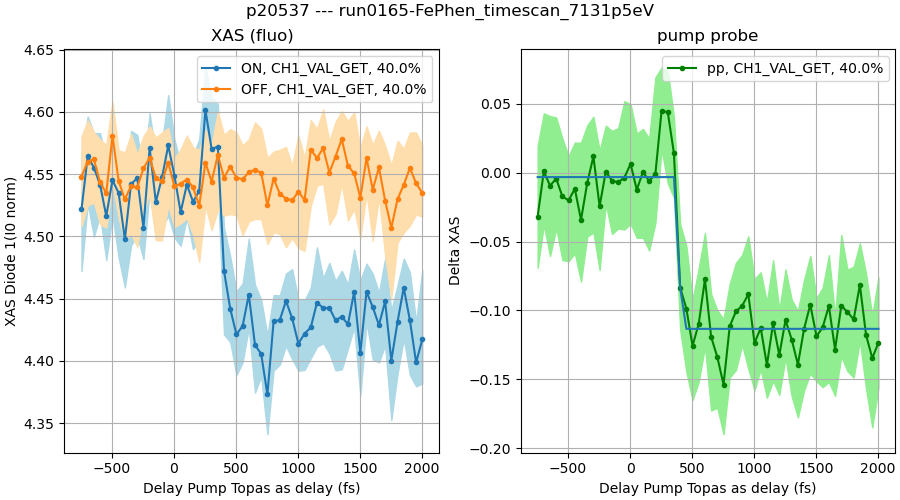

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)
units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
t0_mm = fit.popt[0]
width_fs = fit.popt[2]

print("Position t0 = {:.4f} from {:.4f} mm".format(t0_mm, Timezero_mm))
print("Width = {:.4f} fs".format(width_fs))

ax1.plot(Delay_fs, XAS_pump, label='ON, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS_unpump, label='OFF, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS_pump_probe, label='pp, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.', color = 'g')
ax2.plot(Delay_fs, pp_fit)
ax2.fill_between(Delay_fs, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

## Check correlation for a certain delay point

In [77]:
chosen_delay_fs = 400

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(245,) shots out of (701,) survived
Delay = 448.31 fs


<IPython.core.display.Javascript object>


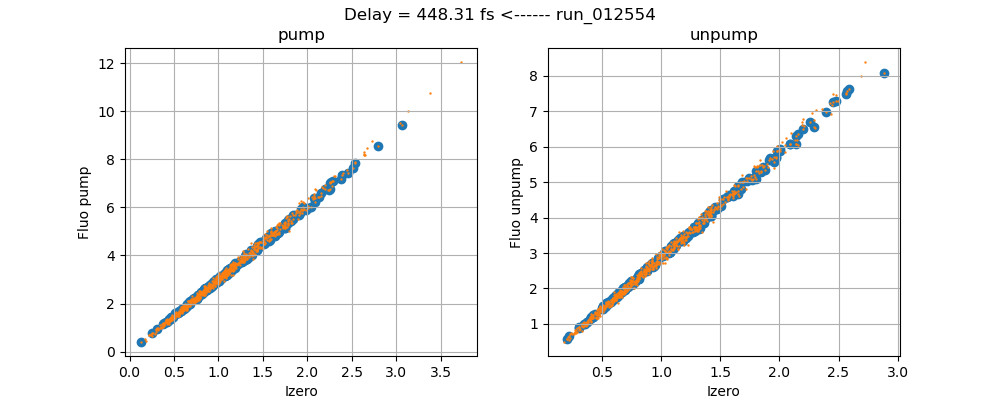

In [78]:
plt.figure(figsize=(10,4))
plt.suptitle('Delay = {:.2f} fs <------ {}'.format(Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

(4409,)

# Loop of scans, WITH TT correction

In [14]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p20537/raw/*FePhen_timescan_7119p5eV*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:]
patch

['/sf/alvra/data/p20537/raw/run0164-FePhen_timescan_7119p5eV/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0166-FePhen_timescan_7119p5eV_001/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0167-FePhen_timescan_7119p5eV_002/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0168-FePhen_timescan_7119p5eV_003/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0169-FePhen_timescan_7119p5eV_004/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0170-FePhen_timescan_7119p5eV_005/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0171-FePhen_timescan_7119p5eV_006/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0172-FePhen_timescan_7119p5eV_007/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0173-FePhen_timescan_7119p5eV_008/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0174-FePhen_timescan_7119p5eV_009/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0175-FePhen_timescan_7119p5eV_010/meta/scan.json']

In [15]:
quantile_corr = 0.4

channel_delay_motor = channel_delay_topas
Timezero_mm = 199.37992 ## 

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

TT = TT_PSEN126
#########################################################
from sfdata import SFScanInfo

Pump_probe_all = []
Delay_fs_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    flag = False

    try:
        flag = True
        Timezero_mm = get_timezero_NBS(json_file)
    except:
        Timezero_mm = Timezero_mm
        
    (Delays_fs_scan, Delays_corr_scan, DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Pump_probe_scan,
    Izero_pump_scan, Izero_unpump_scan, correlation, readbacks, goodshots) = \
    XAS_scanPP_PSEN_bs(scan, TT, channel_delay_motor, detector_XAS, detector_Izero, Timezero_mm, quantile_corr)#, target, px2fs)
    
    Pump_probe_all.extend(Pump_probe_scan)
    Delay_fs_all.extend(Delays_corr_scan)

    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)

Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)

Processing: run0175-FePhen_timescan_7119p5eV_010
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET                 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                 998 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 998 / 1001 -> 0% loss
complete channels: 9 / 10 -> 10% inc

In [16]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_all),np.shape(Delay_fs_all))

binList = np.arange(Delays_fs_scan[0] - 300, Delays_fs_scan[-1] + 300, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 300 + binsize/2, Delays_fs_scan[-1] + 300 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delay_fs_all, Pump_probe_all, statistic='mean', bins=binList)

(48879,) (48879,)


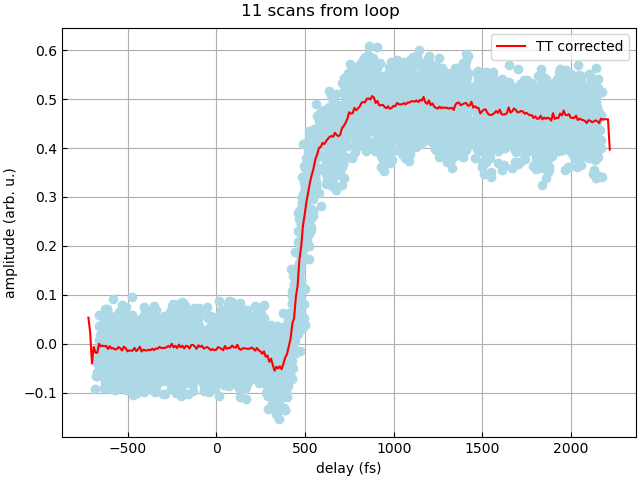

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(f'{len(patch)} scans from loop')

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
#plt.plot(Delay_fs_TT, pp_fit)

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
#                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
#            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

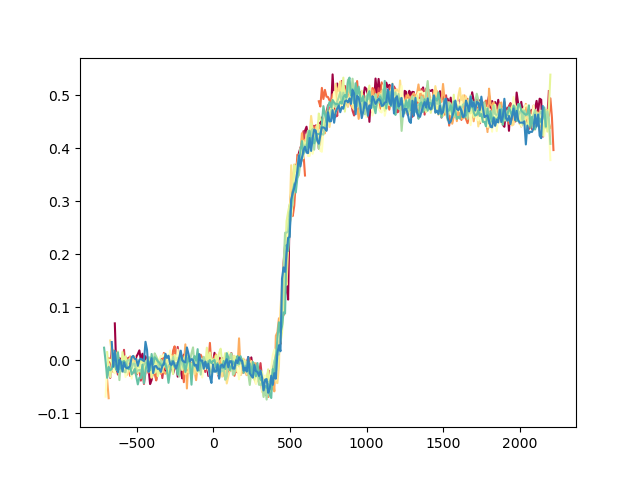

In [99]:

idx = np.concatenate(([0], np.where(np.diff(Delay_fs_all)<-1000)[0]), axis=0)
binList = np.arange(Delays_fs_scan[0] - 300, Delays_fs_scan[-1] + 300, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan[0] - 300 + binsize/2, Delays_fs_scan[-1] + 300 - binsize/2, binsize)

fig, ax = plt.subplots()
ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,11)))

for i in range(len(idx)-1):
    Delay_fs_test = Delay_fs_all[idx[i]:idx[i+1]]
    Pump_probe_test = Pump_probe_all[idx[i]:idx[i+1]]
    pp_TT_test, binEdges_test, binNumber_test = binned_statistic(Delay_fs_test, Pump_probe_test, statistic='mean', bins=binList)
    
    ax.plot(Delay_fs_TT, pp_TT_test, label = 'TT corrected')
# plt.plot(test[idx] )
plt.show()

In [94]:
idx

array([    0,  4450,  8818, 13303, 17772, 22154, 26614, 31023, 35428,
       39906, 44389])